## Unsupervised Anomaly Detection in Multivariate Time Series

### Dataset 2 - Pump Breakdown Dataset
- Data is taken from a pump PdM dataset on Kaggle.
- Raw data has 22,0320 rows.
- 52x anonymised sensor channels.
- 1x machine health channel (with value of either normal, broken or recovering).
- 1x datetime channel (data is recorded with 1 min timestep).
- Goal is identify the breakdown periods & any signs of degradtion pre-breakdown.

**Models Evaluated**: 
* MODEL 1. PCA with Mahalonobis Distance
* MODEL 2. K-means Clustering with Euclidean Distance
* MODEL 3. One-class Support Vector Machine (SVM)
* MODEL 4. Isolation Forest
* MODEL 5. LSTM Autoencoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks
import seaborn as sns

### Data Understanding

#### Load Data

In [2]:
# Water pump sensor data (via Kaggle datasets)
selected_fp = 'data/Pump Sensors/sensor.csv'
df_raw = pd.read_csv(selected_fp, sep = ",")
df_raw['timestamp'].head(3)

0    2018-04-01 00:00:00
1    2018-04-01 00:01:00
2    2018-04-01 00:02:00
Name: timestamp, dtype: object

#### Data Quality Report

In [3]:
df_raw.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [4]:
# Print a data quality report for the numeric data
pdm.generate_dq_num(df_raw.drop(['timestamp', 'machine_status'], axis=1), df_raw.columns.drop(['timestamp', 'machine_status']))

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Data Type,Missing Values,Unique Values,Min Value,Mean Value,Median Value,Max Value
Unnamed: 0,int64,0,220320,0,110159.500000,110159.500000,220319
sensor_00,float64,10208,1253,0.0,2.372221,2.456539,2.549016
sensor_01,float64,369,831,0.0,47.591611,48.133678,56.72743
sensor_02,float64,19,831,33.15972,50.867392,51.649300,56.03299
sensor_03,float64,19,588,31.64062,43.752481,44.227428,48.22049
sensor_04,float64,19,7844,2.798032,590.673936,632.638916,800.0
sensor_05,float64,19,190751,0.0,73.396414,75.576790,99.99988
sensor_06,float64,4798,812,0.014468,13.501537,13.642940,22.25116
sensor_07,float64,5451,531,0.0,15.843152,16.167530,23.59664
sensor_08,float64,5107,626,0.028935,15.200721,15.494790,24.34896


In [5]:
# Convert timestamp to datetime datatype & sort
df_raw = df_raw.drop('Unnamed: 0', axis = 1)\
  .assign(timestamp = lambda x: pd.to_datetime(x['timestamp'], format = '%Y-%m-%d %H:%M:%S'))\
  .sort_values(by = 'timestamp')

In [6]:
# Assign the timestamp as index for easier plotting
df_raw.index = df_raw['timestamp']

In [7]:
# Check on machine status values
print('Reported status types: ', df_raw['machine_status'].unique())

Reported status types:  ['NORMAL' 'BROKEN' 'RECOVERING']


In [8]:
# Print a detailed breakdown of NAs
pdm.check_for_nas(df_raw)

timestamp has 0 NAs			0.0%
sensor_00 has 10208 NAs			4.63%
sensor_01 has 369 NAs			0.17%
sensor_02 has 19 NAs			0.01%
sensor_03 has 19 NAs			0.01%
sensor_04 has 19 NAs			0.01%
sensor_05 has 19 NAs			0.01%
sensor_06 has 4798 NAs			2.18%
sensor_07 has 5451 NAs			2.47%
sensor_08 has 5107 NAs			2.32%
sensor_09 has 4595 NAs			2.09%
sensor_10 has 19 NAs			0.01%
sensor_11 has 19 NAs			0.01%
sensor_12 has 19 NAs			0.01%
sensor_13 has 19 NAs			0.01%
sensor_14 has 21 NAs			0.01%
sensor_15 has 220320 NAs			100.0%
sensor_16 has 31 NAs			0.01%
sensor_17 has 46 NAs			0.02%
sensor_18 has 46 NAs			0.02%
sensor_19 has 16 NAs			0.01%
sensor_20 has 16 NAs			0.01%
sensor_21 has 16 NAs			0.01%
sensor_22 has 41 NAs			0.02%
sensor_23 has 16 NAs			0.01%
sensor_24 has 16 NAs			0.01%
sensor_25 has 36 NAs			0.02%
sensor_26 has 20 NAs			0.01%
sensor_27 has 16 NAs			0.01%
sensor_28 has 16 NAs			0.01%
sensor_29 has 72 NAs			0.03%
sensor_30 has 261 NAs			0.12%
sensor_31 has 16 NAs			0.01%
sensor_32 has 68 NAs			0.03

sensor_15, 50 and 51 contain a large number of NAs.  Consider dropping for this assessment.

#### Data Distributions

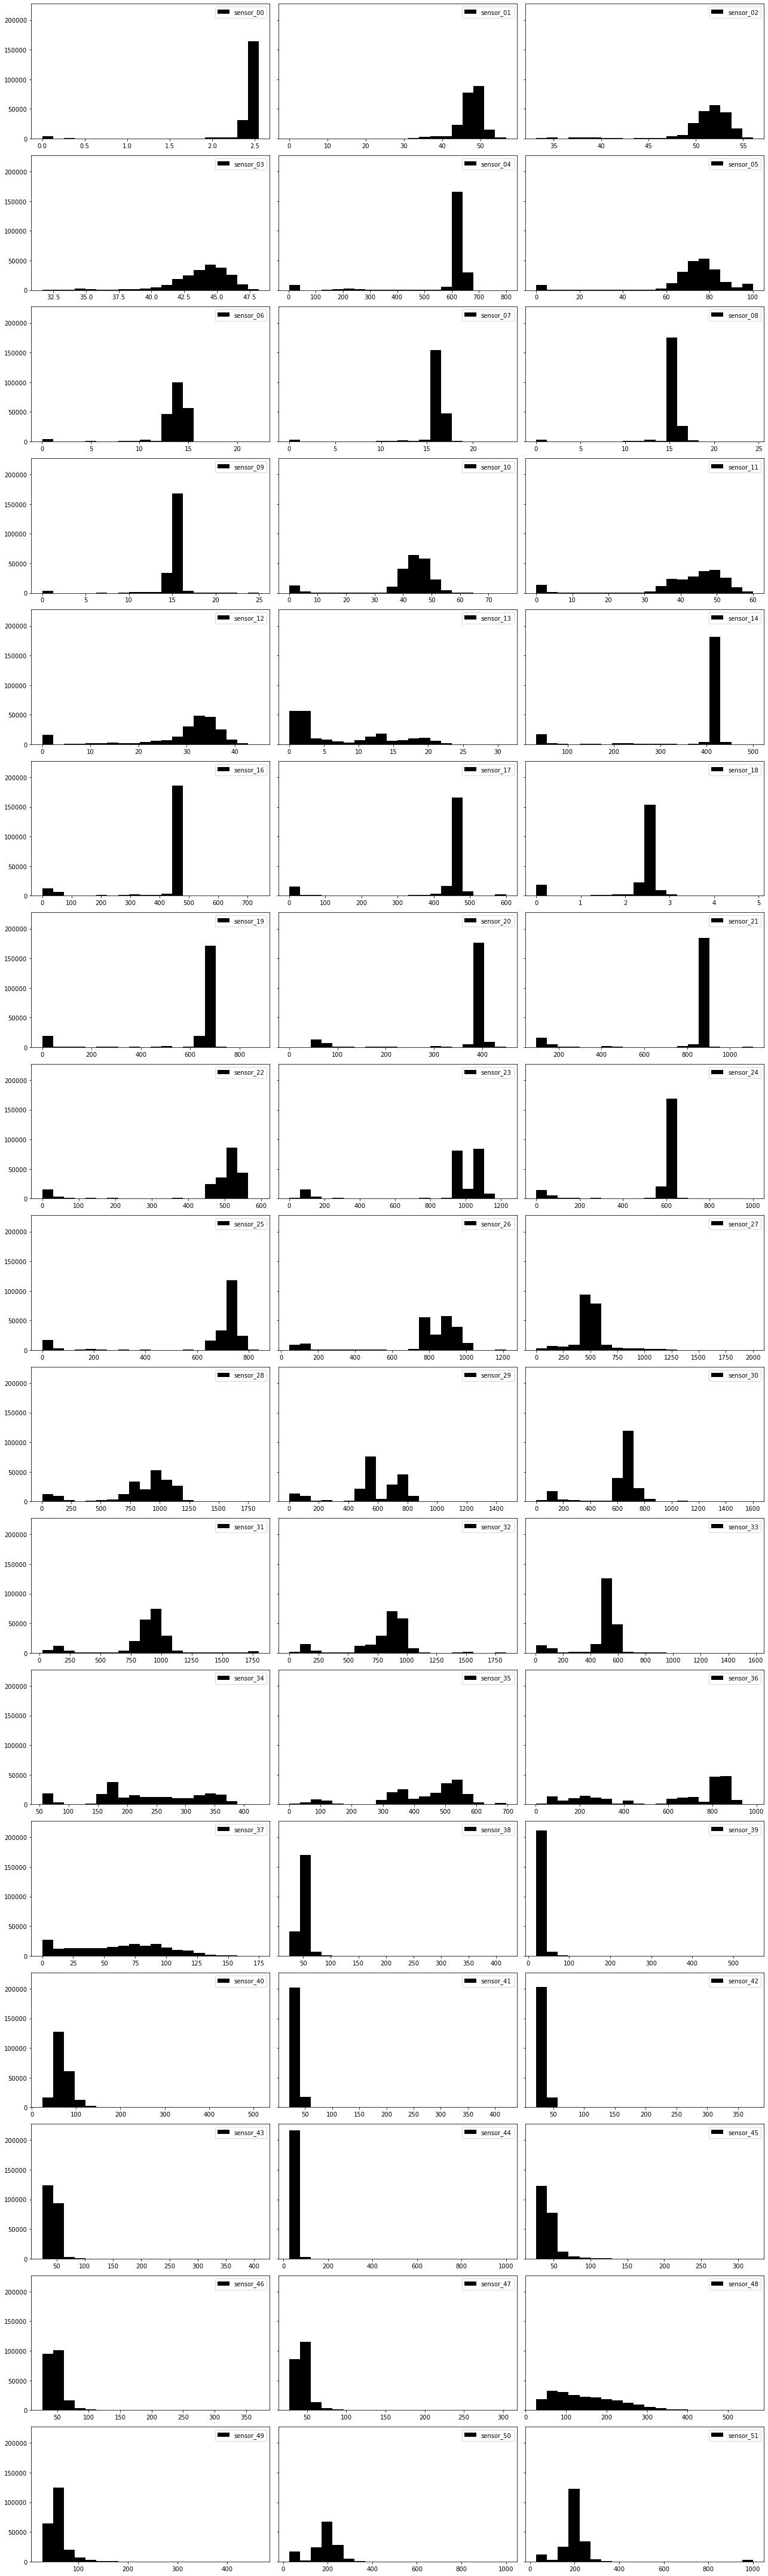

In [9]:
n_bins = 20
fig, axs = plt.subplots(17, 3, sharey=True, tight_layout=True, figsize = (18, 60))
axs = axs.ravel()
drops = ['timestamp', 'machine_status', 'sensor_15']
for p, ref in enumerate(df_raw.columns.drop(drops)):
    axs[p].hist(df_raw[ref].values, bins=n_bins, label = ref, color = 'black')
    axs[p].legend(loc = 'upper right')

Most channels have outliers.  Some unusual distributions.    

#### Correlations

Not practical to generate a scatter plot matrix due to the number of features (52).  Let's use a correlation matrix and heatmap for investigation. 

In [10]:
df_raw.corr(method='pearson', min_periods=1)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
sensor_00,1.000000,0.338561,0.641822,0.388877,0.942803,0.756697,0.750808,0.617905,0.590243,0.521154,...,-0.129328,-0.038068,0.073985,0.055510,0.053538,0.067283,0.283145,0.163604,0.667737,0.427118
sensor_01,0.338561,1.000000,0.737403,0.693155,0.677455,0.162465,0.511725,0.483884,0.459991,0.473874,...,0.089401,0.184414,0.318073,0.285007,0.233236,0.272436,0.344210,0.373514,0.622531,-0.166365
sensor_02,0.641822,0.737403,1.000000,0.822339,0.820339,0.261234,0.661039,0.610840,0.553096,0.595187,...,0.025050,0.138279,0.244899,0.225268,0.201407,0.255338,0.376560,0.339665,0.749069,-0.089978
sensor_03,0.388877,0.693155,0.822339,1.000000,0.682469,0.145979,0.560201,0.494384,0.452998,0.482817,...,0.043680,0.172228,0.307353,0.246027,0.227916,0.273112,0.459639,0.374166,0.618857,-0.157912
sensor_04,0.942803,0.677455,0.820339,0.682469,1.000000,0.386225,0.803788,0.692641,0.626054,0.614365,...,0.000035,0.136460,0.220233,0.162915,0.168666,0.229243,0.394893,0.295388,0.773714,-0.085853
sensor_05,0.756697,0.162465,0.261234,0.145979,0.386225,1.000000,0.594379,0.541405,0.463687,0.503835,...,-0.154082,-0.148699,-0.005592,-0.016752,-0.081389,-0.006863,0.043206,0.021891,0.381239,0.352421
sensor_06,0.750808,0.511725,0.661039,0.560201,0.803788,0.594379,1.000000,0.853007,0.764008,0.775028,...,-0.108767,0.020892,0.238297,0.169548,0.181421,0.198078,0.437859,0.301727,0.608832,0.429183
sensor_07,0.617905,0.483884,0.610840,0.494384,0.692641,0.541405,0.853007,1.000000,0.906744,0.902859,...,-0.038149,0.038047,0.179456,0.142483,0.140464,0.163691,0.302793,0.215687,0.520107,0.350791
sensor_08,0.590243,0.459991,0.553096,0.452998,0.626054,0.463687,0.764008,0.906744,1.000000,0.844928,...,-0.024128,0.040627,0.177039,0.140973,0.137703,0.167273,0.275607,0.199326,0.462673,0.307181
sensor_09,0.521154,0.473874,0.595187,0.482817,0.614365,0.503835,0.775028,0.902859,0.844928,1.000000,...,-0.010254,0.041834,0.148523,0.123925,0.123146,0.156067,0.242133,0.182421,0.471269,0.312101


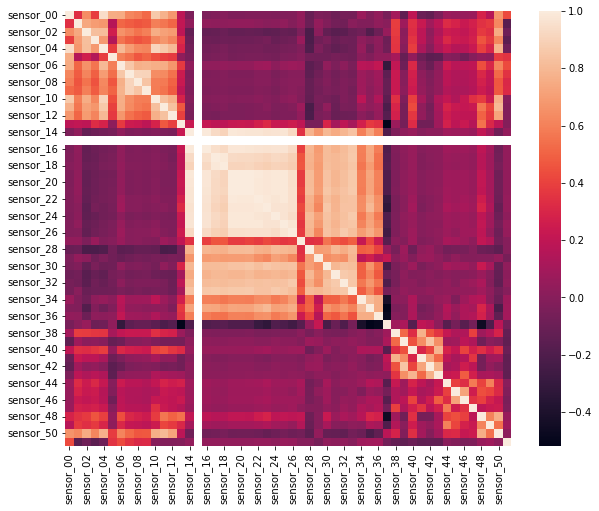

In [11]:
# Plot correlation heatmap
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
dataplot = sns.heatmap(df_raw.corr(method='pearson'))
plt.show()

Several features are strongly correlated with each other.

### Data Preparation

In [12]:
# Drop columns with high degress of missingness
df_set = df_raw.copy(deep=True).drop(['sensor_15', 'sensor_50', 'sensor_51'], axis = 1)

# Replace NAs in remaining data by using last value fill forward method
df_set = df_set.fillna(method = 'ffill')

In [13]:
# Check for NAs again (to verify fill NA has worked)
pdm.check_for_nas(df_set)

timestamp has 0 NAs			0.0%
sensor_00 has 0 NAs			0.0%
sensor_01 has 0 NAs			0.0%
sensor_02 has 0 NAs			0.0%
sensor_03 has 0 NAs			0.0%
sensor_04 has 0 NAs			0.0%
sensor_05 has 0 NAs			0.0%
sensor_06 has 0 NAs			0.0%
sensor_07 has 0 NAs			0.0%
sensor_08 has 0 NAs			0.0%
sensor_09 has 0 NAs			0.0%
sensor_10 has 0 NAs			0.0%
sensor_11 has 0 NAs			0.0%
sensor_12 has 0 NAs			0.0%
sensor_13 has 0 NAs			0.0%
sensor_14 has 0 NAs			0.0%
sensor_16 has 0 NAs			0.0%
sensor_17 has 0 NAs			0.0%
sensor_18 has 0 NAs			0.0%
sensor_19 has 0 NAs			0.0%
sensor_20 has 0 NAs			0.0%
sensor_21 has 0 NAs			0.0%
sensor_22 has 0 NAs			0.0%
sensor_23 has 0 NAs			0.0%
sensor_24 has 0 NAs			0.0%
sensor_25 has 0 NAs			0.0%
sensor_26 has 0 NAs			0.0%
sensor_27 has 0 NAs			0.0%
sensor_28 has 0 NAs			0.0%
sensor_29 has 0 NAs			0.0%
sensor_30 has 0 NAs			0.0%
sensor_31 has 0 NAs			0.0%
sensor_32 has 0 NAs			0.0%
sensor_33 has 0 NAs			0.0%
sensor_34 has 0 NAs			0.0%
sensor_35 has 0 NAs			0.0%
sensor_36 has 0 NAs			0.0%
s

In [14]:
# Apply some cleaning to df_set based on inspection of the timetrace signals
# S1 displays regular spikes without transition points, clamp these (replace with median)
# Any points less than 28,replace with median
s1_med = df_set['sensor_01'].median()
df_set['sensor_01'] = df_set['sensor_01']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 28, cl_val = s1_med, cl_type = 'low'))

s6_med = df_set['sensor_06'].median()
df_set['sensor_06'] = df_set['sensor_06']\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s6_med, cl_type = 'low'))\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 25, cl_val = s6_med, cl_type = 'high'))

# S9 similarly displays some regular spikes that we will assume are spurious
# Any points less than 6 or greater than 21,replace with median
s9_med = df_set['sensor_09'].median()
df_set['sensor_09'] = df_set['sensor_09']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s9_med, cl_type = 'low'))\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 21, cl_val = s9_med, cl_type = 'high'))

In [15]:
# Reduce the dataset to subset
include_cols = [
    'timestamp', 
    'sensor_00',
    'sensor_01',
    'sensor_02',
    'sensor_03',
    'sensor_04',
    'sensor_05',
    'sensor_06',
    'machine_status'
]

In [16]:
# Subset data tagged as 'Normal' operating 
df_norm = df_set.loc[df_set['machine_status'] == 'NORMAL', include_cols]  
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_reco = df_set.loc[df_set['machine_status'] == 'RECOVERING', include_cols] 
df_reco['timestamp'] = pd.to_datetime(df_reco.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_brok = df_set.loc[df_set['machine_status'] == 'BROKEN', include_cols] 
df_brok['timestamp'] = pd.to_datetime(df_brok.index, format = '%Y-%m-%d %H:%M:%S')

#### Plot Events with a Sensor Channel as Backdrop

In [18]:
# Choose a backdrop channel
backdrop_chan = 'sensor_04'

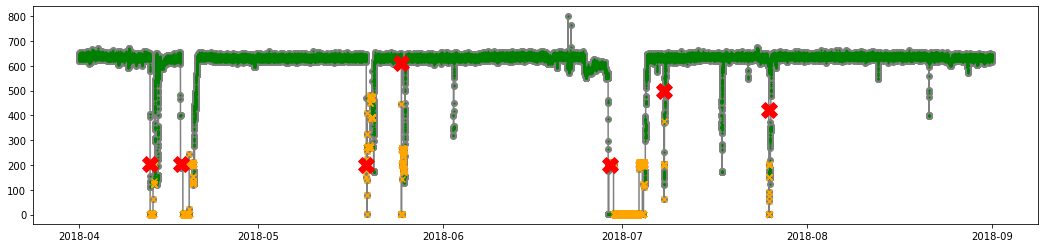

In [17]:
# Visualize machine status over time for the data using backdrop sensor as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set[backdrop_chan], color = 'grey', marker = 'o', zorder = 1)
ax.scatter(df_norm['timestamp'], df_norm[backdrop_chan], color ='green', marker = 'o', zorder = 2, s = 1)
ax.scatter(df_reco['timestamp'], df_reco[backdrop_chan], color ='orange', marker = 'x', zorder = 3)
ax.scatter(df_brok['timestamp'], df_brok[backdrop_chan], color ='red', marker = 'X', zorder = 3, s = 250)
plt.show()

In the plot above, green is normal operating time (as reported), orange zones are when the pump was in a recovering mode and red is the labelled breakdwon.  The time series shows 7x recorded failures with recovery periods.  

#### Scale Data

In [20]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure
from itertools import groupby

In [22]:
# Standardise the data using a standard scaler (mean~0, std ~1)
df_num = df_set.copy(deep=True).drop(['timestamp', 'machine_status'], axis = 1)
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
df_set_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)
df_set_scaled['timestamp'] = df_set['timestamp']
df_set_scaled['machine_status'] = df_set['machine_status']
df_set_scaled.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
count,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,...,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05
mean,7.430512e-17,-4.231264e-16,4.551189e-16,5.263280e-15,-8.091002e-16,-1.562214e-16,5.374737e-15,4.107422e-16,-2.146592e-16,1.444822e-17,...,1.032016e-16,1.139345e-15,2.745161e-16,-1.702826e-16,-5.242639e-16,-2.518118e-16,1.126961e-15,-9.631286e-16,-2.146592e-16,2.229154e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.896670e+00,-4.670490e+00,-4.828443e+00,-5.006965e+00,-4.081218e+00,-4.242232e+00,-7.581048e+00,-4.915887e+00,-5.019891e+00,-1.244306e+01,...,-2.124693e+00,-1.839810e+00,-1.298159e+00,-1.756631e+00,-1.460291e+00,-1.305863e+00,-1.386582e+00,-1.641579e+00,-1.514471e+00,-1.593183e+00
25%,2.357268e-01,-3.906342e-01,-1.299246e-01,-3.777625e-01,2.496240e-01,-1.975963e-01,-3.850899e-01,1.136053e-01,9.298431e-02,1.900798e-02,...,-5.161892e-01,-3.561091e-01,-2.573994e-01,-3.889860e-01,-5.104364e-01,-4.944024e-01,-4.800761e-01,-5.054490e-01,-8.143446e-01,-4.898089e-01
50%,2.979070e-01,1.624558e-01,2.132920e-01,1.964022e-01,2.914071e-01,1.260943e-01,-1.452237e-01,2.122668e-01,1.957313e-01,5.908560e-02,...,-1.140632e-01,-5.936864e-02,-2.893998e-02,-8.244469e-02,-1.854859e-01,-2.239150e-01,-2.025741e-01,-2.006337e-01,-1.564374e-01,-2.328587e-01
75%,3.735289e-01,5.706864e-01,5.210029e-01,6.449691e-01,3.259583e-01,4.344776e-01,7.436908e-01,2.948690e-01,2.789075e-01,1.091619e-01,...,4.221046e-01,3.033131e-01,1.487504e-01,2.476761e-01,2.144531e-01,1.367344e-01,2.044285e-01,2.150238e-01,6.984907e-01,1.903533e-01
max,4.575552e-01,2.769876e+00,1.408636e+00,1.847128e+00,1.453300e+00,1.537773e+00,8.264178e+00,2.568695e+00,3.204744e+00,8.223537e+00,...,2.077212e+01,4.873790e+01,3.302152e+01,3.302398e+01,8.270186e+01,2.159537e+01,2.061006e+01,2.482193e+01,4.994241e+00,2.127538e+01


#### Prepare Normal & Abnormal Datasets 

In [23]:
# Remove periods when pump was broken or covering + a transition window
trans_win = 1*24*60 # Equivalent to 1 day

# Create map to reduce categories to two
# We want to remove 'recovering' so combine it with 'broken'
condition_map = {
    'RECOVERING': 'BROKEN', 
    'NORMAL': 'NORMAL', 
    'BROKEN': 'BROKEN'
}

In [24]:
# Use besploke function from pdm_functions.py for separation.
# This function uses run length encoding to split the data.
df_norm, df_abnorm = pdm.remove_segements(
    segment_vec = df_set_scaled['machine_status'],
    mapping = condition_map,
    dat = df_set_scaled,
    trans_window = trans_win,
    keep = 'NORMAL'
)

Input segement categories:  ['NORMAL' 'BROKEN' 'RECOVERING']
Categories after mapping:  ['NORMAL' 'BROKEN']
Run length encoding:  [('NORMAL', 17155), ('BROKEN', 945), ('NORMAL', 6410), ('BROKEN', 3111), ('NORMAL', 41697), ('BROKEN', 1313), ('NORMAL', 7159), ('BROKEN', 606), ('NORMAL', 49644), ('BROKEN', 8391), ('NORMAL', 4700), ('BROKEN', 42), ('NORMAL', 25267), ('BROKEN', 76), ('NORMAL', 53804)]
>
Skipping NORMAL segment(s)...
>
Remove rows:  [15715, 19539]
Removing 3825 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [23070, 29060]
Removing 5991 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [67878, 72070]
Removing 4193 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [76350, 79835]
Removing 3486 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [126600, 137870]
Removing 11271 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [139691, 142612]
Removing 2922 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [165000, 167955]
Removing 2956 rows..

In [25]:
# Quick check to confirm only one category 'normal' remains in the data
print('Remaining category:', df_norm['machine_status'].unique())
print('Remaining columns:', df_norm.columns)

Remaining category: ['NORMAL']
Remaining columns: Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'timestamp',
       'machine_status'],
      dtype='object')


In [26]:
# Check row counts
tot_rows = len(df_norm) + len(df_abnorm)
print('Nrows normal: ' + str(len(df_norm)) + ' (' + str(round(100*len(df_norm)/tot_rows)) + '%)')
print('Nrows abnorm: ' + str(len(df_abnorm)) + ' (' + str(round(100*len(df_abnorm)/tot_rows)) + '%)')

Nrows normal: 185676 (84%)
Nrows abnorm: 34644 (16%)


In [27]:
# Create a timestamp column
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')
df_abnorm['timestamp'] = pd.to_datetime(df_abnorm.index, format = '%Y-%m-%d %H:%M:%S')

In [28]:
# Split abnormal now into its different categories
df_abnorm_lead = df_abnorm.loc[df_abnorm['machine_status'] == 'NORMAL', include_cols] 
print('Test dataset 1', df_abnorm_lead['machine_status'].unique())

df_abnorm_broke = df_abnorm.loc[df_abnorm['machine_status'] == 'BROKEN', include_cols] 
print('Test dataset 2', df_abnorm_broke['machine_status'].unique())

df_abnorm_recover = df_abnorm.loc[df_abnorm['machine_status'] == 'RECOVERING', include_cols] 
print('Test dataset 3', df_abnorm_recover['machine_status'].unique())

Test dataset 1 ['NORMAL']
Test dataset 2 ['BROKEN']
Test dataset 3 ['RECOVERING']


In [29]:
# Prepare data for PCA
cut_date = pd.to_datetime('2018-08-01 00:00:00', format = '%Y-%m-%d %H:%M:%S')
df_train = df_norm.loc[:, include_cols] 
head = df_train.loc[df_train['timestamp'] <= cut_date,:]
tail = df_train.loc[df_train['timestamp'] > cut_date,:]
df_train = head.drop(['machine_status', 'timestamp'], axis = 1)                      

boundaries = df_abnorm_lead.loc[:, include_cols]
df_test1 = pd.concat([boundaries, tail])
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1) 

In [32]:
df_train

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06
timestamp,,,,,,,
2018-04-01 00:00:00,0.314712,-0.153596,0.639354,1.057648,0.303460,0.177150,-0.356866
2018-04-01 00:01:00,0.314712,-0.153596,0.639354,1.057648,0.303460,0.177150,-0.356866
2018-04-01 00:02:00,0.279421,-0.074582,0.639354,1.093535,0.334797,0.008734,-0.441528
2018-04-01 00:03:00,0.306308,-0.153596,0.627520,1.093534,0.260070,0.207740,-0.448580
2018-04-01 00:04:00,0.281102,-0.140428,0.639354,1.093534,0.317923,0.184619,-0.413304
...,...,...,...,...,...,...,...
2018-07-31 23:56:00,0.294545,-0.272114,0.047601,0.375829,0.403900,0.498511,0.743691
2018-07-31 23:57:00,0.297907,-0.285282,0.047602,0.375829,0.382205,0.456162,0.807180
2018-07-31 23:58:00,0.291183,-0.285283,0.047602,0.375829,0.350867,0.463097,0.849517


### MODEL 1. Principle Component Analysis (PCA)

In [30]:
# Define the PCA model (all compoments)
# from sklearn.decomposition import PCA, KernelPCA
n_comps = 4 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

# Project the test data onto the PCA space
X_test2_PCA = pca.transform(df_test2)
X_test2_PCA = pd.DataFrame(X_test2_PCA)
X_test2_PCA.index = df_test2.index

# Project the test data onto the PCA space
X_test3_PCA = pca.transform(df_test3)
X_test3_PCA = pd.DataFrame(X_test3_PCA)
X_test3_PCA.index = df_test3.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.418 0.244 0.151 0.115]


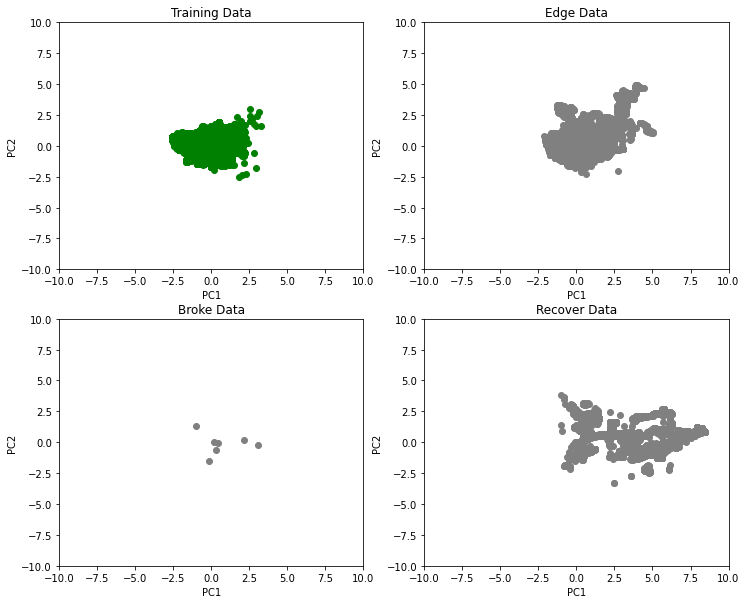

In [33]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-10, 10)
ax0.set_ylim(-10, 10)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_PCA.loc[:, 0], X_test2_PCA.loc[:, 1], color = 'grey')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_PCA.loc[:, 0], X_test3_PCA.loc[:, 1], color = 'grey')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)
ax3.set_title('Recover Data')

plt.show()

The edge and recovery data are noticeably different than the training (normal data).  Edge data includes 1 day before and after the event/recovery.

In [34]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)
data_test2 = np.array(X_test2_PCA.values)
data_test3 = np.array(X_test3_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [-5.481e-17  5.320e-17 -4.836e-17  2.338e-17]
Minimum & maximum MD in training set: 0.12075559916581399 8.243056578257967
Minimum & maximum MD in test set 1  : 0.1447287075904004 14.999083428098828
Minimum & maximum MD in test set 2  : 1.217220911040266 9.897126182959088
Minimum & maximum MD in test set 3  : 1.130985121768432 19.03405041514895
Threshold value for flagging an anomaly is 5.59


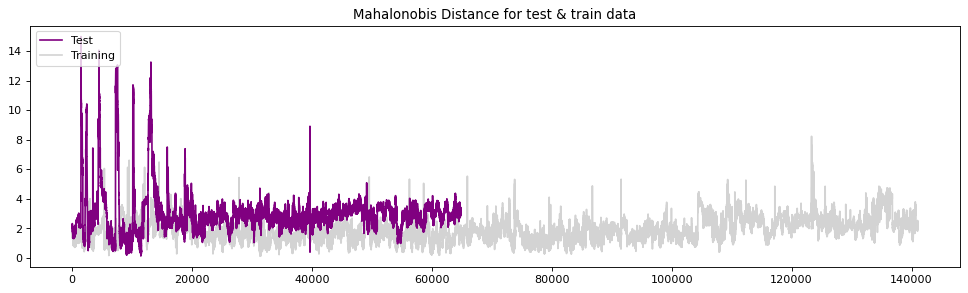

In [35]:
figure(figsize = (15, 4), dpi = 80)
plt.plot(np.array(dist_test1), label = "Test", color = 'purple', zorder = 2)
plt.plot(np.array(dist_train) , label = "Training", color = 'lightgrey', zorder = 1)
plt.legend(loc = "upper left")
plt.title("Mahalonobis Distance for test & train data")
plt.show()

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


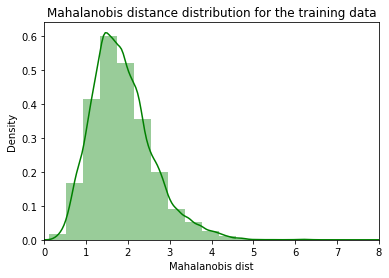

In [36]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde = True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [37]:
def prep_mahalonobis_data (dist_dat, thresh, pca_dat):
    # Prepare test data for visualization
    dat = pd.DataFrame()
    dat['Mob dist'] = dist_dat
    dat['Thresh'] = thresh
    dat['Anomaly'] = dat['Mob dist'] > dat['Thresh']
    dat.index = pca_dat.index
    dat['timestamp'] = dat.index

    n_outliers = dat[dat['Anomaly'] == True].shape[0]
    print("There are", n_outliers, "anomalies in the test set out of", dat.shape[0], "points")
    print("Corresponding to " + str(round(100*(n_outliers / dat.shape[0]), 2)) + '%')

    return(dat)

In [38]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = pdm.prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = pdm.prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = pdm.prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = pdm.prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

There are 78 anomalies in the test set out of 141037 points
> Corresponding to 0.06%
There are 2855 anomalies in the test set out of 64799 points
> Corresponding to 4.41%
There are 2 anomalies in the test set out of 7 points
> Corresponding to 28.57%
There are 14345 anomalies in the test set out of 14477 points
> Corresponding to 99.09%


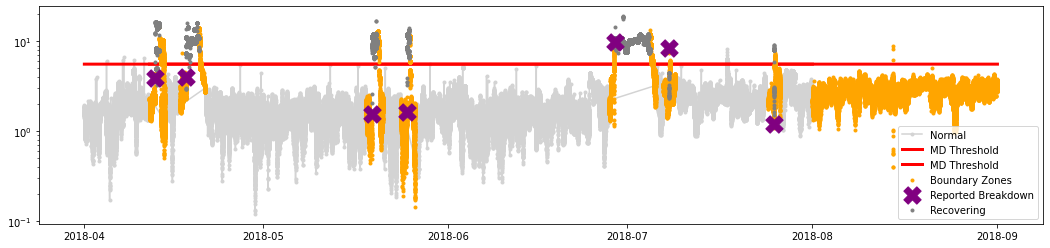

In [39]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
ax.plot(anomaly1['timestamp'], anomaly1['Thresh'], color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Reported Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
plt.show()

### Robust Principle Component Analysis (R-PCA)

In [ ]:
# Prepare data for Robust PCA
cut_date = pd.to_datetime('2018-08-01 00:00:00', format = '%Y-%m-%d %H:%M:%S')
df_train = df_norm.loc[:, include_cols] 
head = df_train.loc[df_train['timestamp'] <= cut_date,:]
tail = df_train.loc[df_train['timestamp'] > cut_date,:]
df_train = head.drop(['machine_status', 'timestamp'], axis = 1)                      

boundaries = df_abnorm_lead.loc[:, include_cols]
df_test1 = pd.concat([boundaries, tail])
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1) 

# Compute all PCA components for the training set
L_train, S_train = pdm.R_pca(df_train).fit()
X_train_PCA = pca.fit_transform(L_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
#L_test1, S_test1 = pdm.R_pca(df_test1).fit() # don't do
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

#L_test2, S_test2 = pdm.R_pca(df_test2).fit()
X_test2_PCA = pca.transform(df_test2)
X_test2_PCA = pd.DataFrame(X_test2_PCA)
X_test2_PCA.index = df_test2.index

#L_test3, S_test3 = pdm.R_pca(df_test3).fit()
X_test3_PCA = pca.transform(df_test3)
X_test3_PCA = pd.DataFrame(X_test3_PCA)
X_test3_PCA.index = df_test3.index

In [ ]:
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress = True) 
print('Explained variance:', pca.explained_variance_ratio_)

In [ ]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-10, 10)
ax0.set_ylim(-10, 10)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_PCA.loc[:, 0], X_test2_PCA.loc[:, 1], color = 'grey')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_PCA.loc[:, 0], X_test3_PCA.loc[:, 1], color = 'grey')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)
ax3.set_title('Recover Data')

plt.show()

In [ ]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)
data_test2 = np.array(X_test2_PCA.values)
data_test3 = np.array(X_test3_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = 2x else 3x
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

In [ ]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde= True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [ ]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

In [ ]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.scatter(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = None, linewidth=3, zorder = 6, label = 'MD Threshold')
ax.plot(anomaly1['timestamp'], anomaly1['Thresh'], color = 'red', marker = None, linewidth=3, zorder = 6, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Reported Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
plt.show() 

In [ ]:
"""
Visualize Mahalonobis distance with actual anomalies vs threshold 
Zoom in on each breakdown period & examine distance in lead up to 
the reporting of the machine as 'broken'
""" 
start_slice = [ # Start times for zoomed views
    pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-05-17 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-06-25 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-23 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
ender_slice = [ # End times for zoomed views
    pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-05-29 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-11 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-29 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
# Loop through and plot each zoomed view
for i in range(4):
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.scatter(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
    ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = None, linewidth=3, zorder = 2, label = 'MD Threshold')
    ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
    ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Reported Breakdown')
    ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
    ax.set_yscale('log')
    ax.set_xlim(start_slice[i], ender_slice[i]),
    ax.legend(loc = 'lower right')
    plt.show()

### Uniform Manifold Approximation & Projection (UMAP)
https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [ ]:
import umap

In [ ]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

# Fit & transform training data using UMAP
reducer = umap.UMAP(n_neighbors = 5, min_dist = 0.1) # 5, 10, 15
X_train_UMAP = reducer.fit_transform(df_train)
print('UMAP embeddings shape', X_train_UMAP.shape)

In [ ]:
# Project test data on to the UMAP sapce
X_test1_UMAP = reducer.transform(df_test1)
X_test2_UMAP = reducer.transform(df_test2)
X_test3_UMAP = reducer.transform(df_test3)

In [ ]:
X_train_UMAP = pd.DataFrame(X_train_UMAP)
X_train_UMAP.index = df_train.index

X_test1_UMAP = pd.DataFrame(X_test1_UMAP)
X_test1_UMAP.index = df_test1.index

X_test2_UMAP = pd.DataFrame(X_test2_UMAP)
X_test2_UMAP.index = df_test2.index

X_test3_UMAP = pd.DataFrame(X_test3_UMAP)
X_test3_UMAP.index = df_test3.index

In [ ]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_UMAP.loc[:, 0], X_train_UMAP.loc[:, 1], color = 'green')
ax0.set_xlabel('UMAP1')
ax0.set_ylabel('UMAP2')
ax0.set_xlim(-20, 30)
ax0.set_ylim(-20, 30)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_UMAP.loc[:, 0], X_test1_UMAP.loc[:, 1], color = 'grey')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('UMAP2')
ax1.set_xlim(-20, 30)
ax1.set_ylim(-20, 30)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_UMAP.loc[:, 0], X_test2_UMAP.loc[:, 1], color = 'grey')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')
ax2.set_xlim(-20, 30)
ax2.set_ylim(-20, 30)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_UMAP.loc[:, 0], X_test3_UMAP.loc[:, 1], color = 'grey')
ax3.set_xlabel('UMAP1')
ax3.set_ylabel('UMAP2')
ax3.set_xlim(-20, 30)
ax3.set_ylim(-20, 30)
ax3.set_title('Recover Data')

plt.show()

In [ ]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_UMAP)
data_test1 = np.array(X_test1_UMAP)
data_test2 = np.array(X_test2_UMAP)
data_test3 = np.array(X_test3_UMAP)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

In [ ]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde= True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [ ]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = prep_mahalonobis_data(dist_train, threshold, X_train_UMAP)
anomaly1 = prep_mahalonobis_data(dist_test1, threshold, X_test1_UMAP)
anomaly2 = prep_mahalonobis_data(dist_test2, threshold, X_test2_UMAP)
anomaly3 = prep_mahalonobis_data(dist_test3, threshold, X_test3_UMAP)

In [ ]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
ZOOM = False
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = '.', zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Actual Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
if ZOOM is True:
    ax.set_xlim(
        pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
        pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S')
    )
ax.legend(loc = 'lower right')
plt.show()

### One-class Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

In [ ]:
# Train a one-class SVM 
# nu = contamination 
svm_model =  OneClassSVM(nu = 0.01) 
svm_model.fit(pd.DataFrame(df_train))

In [ ]:
# Predict for train set (normal operating)
preds = pd.Series(svm_model.predict(df_train))
test = pd.DataFrame({'sensor_04':pd.Series(df_train['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
sensor_04 = df_train['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly0 = svm_aly

In [ ]:
# Predict for test set 1 (boundary segments)
preds = pd.Series(svm_model.predict(df_test1))
test = pd.DataFrame({'sensor_04':pd.Series(df_test1['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
sensor_04 = df_test1['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly1 = svm_aly

In [ ]:
# Predict for test set 2 (breakdown points)
preds = pd.Series(svm_model.predict(df_test2))
test = pd.DataFrame({'sensor_04':pd.Series(df_test2['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test2.index, 'Prediction':preds})
sensor_04 = df_test2['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly2 = svm_aly

In [ ]:
# Predict for test set 3 (recovery points)
preds = pd.Series(svm_model.predict(df_test3))
test = pd.DataFrame({'sensor_04':pd.Series(df_test3['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test3.index, 'Prediction':preds})
sensor_04 = df_test3['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly3 = svm_aly

In [ ]:
lam

### Isolation Forest

Overview of Isolation forest steps:
https://ieeexplore.ieee.org/abstract/document/4781136
1. Build trees,
2. Pass each data point through each tree,
3. Calculate the average path that is required to isolate the point.
4. The shorter the path, the higher the anomaly score.

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

In [ ]:
# Train isolation forest 
isfo_model =  IsolationForest(contamination = 0.01)
isfo_model.fit(df_train)

In [ ]:
# Predict for train set (normal operating)
preds = pd.Series(isfo_model.predict(df_train))
test = pd.DataFrame({'sensor_04':pd.Series(df_train['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
sensor_04 = df_train['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly0 = isfo_aly

In [ ]:
# Predict for test set 1 ()
preds = pd.Series(isfo_model.predict(df_test1))
test = pd.DataFrame({'sensor_04':pd.Series(df_test1['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
sensor_04 = df_test1['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly1 = isfo_aly

In [ ]:
# Predict for test set 2 ()
preds = pd.Series(isfo_model.predict(df_test2))
test = pd.DataFrame({'sensor_04':pd.Series(df_test2['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test2.index, 'Prediction':preds})
sensor_04 = df_test2['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly2 = isfo_aly

In [ ]:
# Predict for test set 3 ()
preds = pd.Series(isfo_model.predict(df_test3))
test = pd.DataFrame({'sensor_04':pd.Series(df_test3['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test3.index, 'Prediction':preds})
sensor_04 = df_test3['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly3 = isfo_aly

In [ ]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
ax.scatter(isfo_aly0['timestamp'], isfo_aly0['sensor_04'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
ax.scatter(isfo_aly1['timestamp'], isfo_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
ax.scatter(isfo_aly2['timestamp'], isfo_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 5, label = 'Anomaly: Breakdown')
ax.scatter(isfo_aly3['timestamp'], isfo_aly3['sensor_04'], color ='grey', marker = '.', zorder = 3, label = 'Anomaly: Recovery')
ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 4, s = 350, label = 'Actual Breakdwon')
ax.legend(loc = 'lower right')
plt.show()

### LSTM

RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [ ]:
data_n = df_set_scaled.drop(['timestep', 'machine_status]', axis = 1)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 700
unroll_length = 50 # consider n last datapoints (this will be sequence length)
testdatacut = testdatasize + unroll_length  + 1

pred_chan = 'sensor_04'

# train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut][pred_chan].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:][pred_chan].values

# See the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
#unroll: create sequence of 50 previous data points for each data point
def unroll(data, sequence_length = 24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# Adapt the datasets for the sequence data shape
x_train = unroll(x_train, unroll_length)
x_test  = unroll(x_test, unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# See the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
# Load libraries for RNN
# Keras acts as an interface for the TensorFlow library
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [ ]:
# Build the model
lstm_model = Sequential()

In [ ]:
lstm_model.add(LSTM(
    #input_shape = x_train.shape[-1],
    return_sequences = True,
    units = 50))

In [ ]:
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100, return_sequences = False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.add(Activation('linear'))

start = time.time()
lstm_model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

In [ ]:
# Train the model

# Some notes on hyperparameters:
# ==============================
# Batch Size: Hyperparameter of gradient descent that controls the no. of 
# training samples to work through before the model’s internal parameters are updated.

"""
- Batch Gradient Descent: Batch Size = Size of Training Set
- Stochastic Gradient Descent: Batch Size = 1
- Mini-Batch Gradient Descent: 1 < Batch Size < Size of Training Set
In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples.
"""

# Epochs: Hyperparameter of gradient descent that controls the number of complete 
# passes through the training dataset.

lstm_model.fit(
    x_train,
    y_train,
    batch_size = 3028, # TODO -- Update
    epochs = 30,
    validation_split = 0.1)

In [ ]:
# Create the list of difference between prediction and test data
loaded_model = lstm_model
diff = []
ratio = []
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [ ]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p, color = 'red', label = 'prediction')
axs.plot(y_test, color = 'grey', label = 'actual')
plt.legend(loc = 'upper left')
plt.show()

### LSTM Autoencoder

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import keras

In [ ]:
# set random seed
seed(13)
tf.random.set_seed(13)

In [ ]:
# Refresh the data
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)    
df_train_df = df_train
df_train = df_train.to_numpy()

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  
df_test1_df = df_test1
df_test1 = df_test1.to_numpy()

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  
df_test2_df = df_test2
df_test2 = df_test2.to_numpy()

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)
df_test3_df = df_test3
df_test3 = df_test3.to_numpy()

In [ ]:
# Reshape inputs for LSTM [samples, timesteps, features]
X_train = df_train.reshape(df_train.shape[0], 1, df_train.shape[1])
print("Training data shape:", X_train.shape)

X_test1 = df_test1.reshape(df_test1.shape[0], 1, df_test1.shape[1])
print("Test data 1 shape:", X_test1.shape)

X_test2 = df_test2.reshape(df_test2.shape[0], 1, df_test2.shape[1])
print("Test data 2 shape:", X_test2.shape)

X_test3 = df_test3.reshape(df_test3.shape[0], 1, df_test3.shape[1])
print("Test data 3 shape:", X_test3.shape)

In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Create the autoencoder model
model = autoencoder_model(X_train)
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

In [ ]:
# Fit the model to the data
nb_epochs = 80
batch_size = 1000
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

In [ ]:
# Plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# Plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train_df.columns)
X_pred.index = df_train_df.index

scored = pd.DataFrame(index=df_train_df.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0, 0.5])

In [ ]:
def calc_test_loss(test, test_df, thresh):
    # Calculate the loss on the test set 1
    X_pred = model.predict(test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test_df.columns)
    X_pred.index = test_df.index

    scored = pd.DataFrame(index=test_df.index)
    Xtest = test.reshape(test.shape[0], test.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis=1)
    scored['Threshold'] = thresh
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    print(scored.head())
    return(scored)

In [ ]:
# Calculate the loss on the test set 1
selected_threshold = 0.12
scored1 = calc_test_loss(X_test1, df_test1_df, selected_threshold)
scored2 = calc_test_loss(X_test2, df_test2_df, selected_threshold)
scored3 = calc_test_loss(X_test3, df_test3_df, selected_threshold)

In [ ]:
# Calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train_df.columns)
X_pred_train.index = df_train_df.index

scored_train = pd.DataFrame(index=df_train_df.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.12
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

scored = pd.concat([scored_train, scored1, scored2, scored3])
scored.head()

In [ ]:
# plot bearing failure time plot
scored.plot(logy = True,  figsize=(16, 9), ylim=[1e-2, 1e2], color=['blue','red'])

In [ ]:
scored['Threshold'].unique()

In [ ]:
# Save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")